# run a forward simulation of a UXO 
the goal here is to check that we understand the black tusk simulation, and in particular are correctly accounting for orientations of the UXO and system

In [1]:
import discretize
import numpy as np
from matplotlib import pyplot as plt
import SimPEG as simpeg
import geoana
import scipy.sparse as sp

import polarizability_model as pm
import uxo_utils

from matplotlib import rcParams
rcParams["font.size"] = 14

## Start simple: conincident loop system

In [2]:
# define system geometry -- transmitter is a horizontal square loop,
# receivers are in the centre, measure x, y, z data
rx_width=0.02
sensorinfo = uxo_utils.CustomSensorInfo.coincident_system(
    tx_width=1, rx_width=rx_width
)
ordnance = uxo_utils.load_ordnance_dict()

In [3]:
times = ordnance["4-in Sphere"]["times"]
sensor_table = sensorinfo.measNum2TxRxRxcCube()

In [4]:
n_lines = 1
line_length = 3
line_spacing = 0.5*line_length/n_lines
z_tx = 0.25

survey_dict = uxo_utils.create_survey(
    sensorinfo,
    times, 
    line_length=line_length,
    along_line_spacing=0.05,
    line_spacing=line_spacing,
    n_lines=n_lines,
    starting_point=np.r_[-1, 0]*line_length/2,
    z=z_tx,
    pitch=0,
    roll=0,
    yaw=0,
)

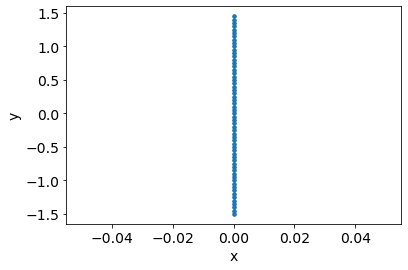

In [5]:
fig, ax = plt.subplots(1,1)

for l in np.unique(survey_dict["line"]): 
    inds = survey_dict["line"] == l
    ax.plot(
        survey_dict["pos"][inds, 0], survey_dict["pos"][inds, 1], ".", 
        color="C1" if np.all(survey_dict["yaw"][inds] > np.pi/2 ) else "C0"
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")

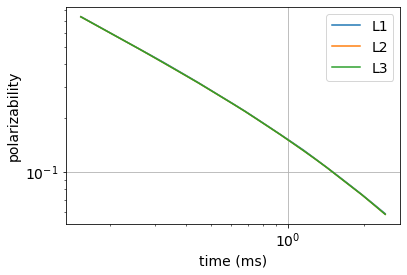

In [7]:
ord_key = "4-in Sphere" # "ISO Small"
ord_ind = 0  # there are multiple realizations of each in the library
ord_loc = np.r_[0, 0, -0.25]
ord_ypr = np.r_[0, 0, 0]

# Black Tusk likes to treat L1 as the largest, 
# which is opposite to the ordnance dictionary
L1, L2, L3 = (ordnance[ord_key][l][ord_ind] for l in ["L3", "L2", "L1"])

fig, ax = plt.subplots(1, 1)
for i, L in enumerate([L1, L2, L3]):
    ax.loglog(times, L, label=f"L{i+1}")

ax.grid()
ax.set_xlabel("time (ms)")
ax.set_ylabel("polarizability")
ax.legend();

In [8]:
fwd_params = uxo_utils.create_forward_modelling_params(
    sensorinfo, 
    times, 
    mnum=survey_dict["mnum"], 
    pos=survey_dict["pos"], 
    pitch=survey_dict["pitch"], 
    roll=survey_dict["roll"], 
    yaw=survey_dict["yaw"]
)

### Compute data 

with black tusk code 

In [9]:
data_bt = uxo_utils.simulate_object(
    L1, L2, L3, fwd_params, times, ord_loc, ord_ypr
)

set up our own simulation

In [10]:
src_list = []
nrx = len(sensorinfo.receivers)
rx_area = np.max(np.abs(np.diff(sensorinfo.receivers[0].shape, axis=0)))**2

for i, txi in enumerate(survey_dict["txnum"]):
    tx = sensorinfo.transmitters[txi]
    tx_corners = tx.shape + survey_dict["xyz"][i, :]
    tx_corners = np.vstack([tx_corners, tx_corners[:1, :]])  # close the loop

    receivers = pm.MagneticFluxDensityReceiver(
        np.atleast_2d(survey_dict["xyz"][i, :]), 
        components=[rx.component for rx in sensorinfo.receivers],
        area=rx_area
    )
    src = pm.MagneticControlledSource(
        receiver_list=[receivers], location=tx_corners, current=1
    )
    src_list.append(src)

In [11]:
A = np.array([
    [np.cos(ord_ypr[0])*np.cos(ord_ypr[1])*np.cos(ord_ypr[2])-np.sin(ord_ypr[0])*np.sin(ord_ypr[2]),   np.cos(ord_ypr[0])*np.cos(ord_ypr[1])*np.sin(ord_ypr[2])+np.sin(ord_ypr[0])*np.cos(ord_ypr[2]),  -np.cos(ord_ypr[0])*np.sin(ord_ypr[1])],
    [-np.sin(ord_ypr[0])*np.cos(ord_ypr[1])*np.cos(ord_ypr[2])-np.cos(ord_ypr[0])*np.sin(ord_ypr[2]), -np.sin(ord_ypr[0])*np.cos(ord_ypr[1])*np.sin(ord_ypr[2])+np.cos(ord_ypr[0])*np.cos(ord_ypr[2]),   np.sin(ord_ypr[0])*np.sin(ord_ypr[1])],
    [np.sin(ord_ypr[1])*np.cos(ord_ypr[2]),                        np.sin(ord_ypr[1])*np.sin(ord_ypr[2]),                        np.cos(ord_ypr[1])]
])


In [12]:
def get_L_matrix(i): 
    return np.diag([L1[i], L2[i], L3[i]])

polarizabilities = [A @ get_L_matrix(i) @ A.T for i in range(len(times))]

In [13]:
rx_shape = sensorinfo.receivers[0].shape
rx_area = (2*np.abs(rx_shape[1, 1]))**2

In [14]:
def get_G_receiver(src):
    receivers = src.receiver_list[0]  # hard coded for single 3 component receiver
    vector_distance = (
        receivers.locations[None, :, :] - np.atleast_2d(ord_loc)[:, None, :]
    )
    distance = np.linalg.norm(vector_distance, axis=2)
    rhat = vector_distance / distance[:, :, None]
    G_rx = 1 / (4*np.pi) * np.vstack([(
        1/distance[:, i]**3 * (3*np.outer(rhat[:, i, :], rhat[:, i, :]) - np.eye(3))
        ) for i in range(rhat.shape[1])
    ])
    return G_rx

In [15]:
data = np.empty((3, len(src_list), len(times)))

# this could be easily parallelized
for i, src in enumerate(src_list): 
    src_field_uxo = src.eval(np.atleast_2d(ord_loc))
    G_rx = get_G_receiver(src)
    for j, P in enumerate(polarizabilities):
        moment = P @ src_field_uxo
        data[:, i, j] = G_rx @ moment * rx_area

In [16]:
data_geoana = np.empty((3, len(src_list), len(times)))

# this could be easily parallelized
for i, src in enumerate(src_list): 
    src_field_uxo = src.eval(np.atleast_2d(ord_loc))
    rx_loc = src.receiver_list[0].locations
    for j, P in enumerate(polarizabilities):
        moment = P @ src_field_uxo
        dipoles = [
            geoana.em.static.MagneticDipoleWholeSpace(
                location=ord_loc, moment=moment[k], orientation=["x", "y", "z"][k]
            )
            for k in range(3)
        ]
        data_geoana[:, i, j] = sum([d.magnetic_field(rx_loc) for d in dipoles]) * rx_area
        

In [17]:
data_pm = np.empty((3, len(src_list), len(times)))
survey = pm.Survey(src_list)

sim = pm.SimulationPolarizabilityModel(np.atleast_2d(ord_loc), survey)
for j, P in enumerate(polarizabilities): 
    data_pm[:, :, j] = sum([sim.dpred(P[:, k]) for k in range(3)]).reshape(survey_dict["xyz"].shape[0], 3).T

In [18]:
def plot_data_profile(data_plot, line_id=0, tind=0, ax=None): 
    if ax is None: 
        fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))

    inds = survey_dict["line"].reshape(survey_dict["xyz"].shape)[:, 0] == line_id
    for i, comp in enumerate(["x", "y", "z"]):
        ax[i].plot(
            survey_dict["xyz"][inds, 1], data_plot[i, inds, tind], "-o", label=comp, 
            ms=2, color="k", alpha=1
        )
        ax[i].plot(
            survey_dict["xyz"][inds, 1], data_plot[i, inds, :], "-", label=comp, 
            color="k", alpha=0.4
        )
        ax[i].set_title(f"{comp}")
        ax[i].set_xlabel("along line (m)")

    ax[0].set_ylabel("db/dt")

    plt.tight_layout()
    return ax

array([<AxesSubplot:title={'center':'x'}, xlabel='along line (m)', ylabel='db/dt'>,
       <AxesSubplot:title={'center':'y'}, xlabel='along line (m)'>,
       <AxesSubplot:title={'center':'z'}, xlabel='along line (m)'>],
      dtype=object)

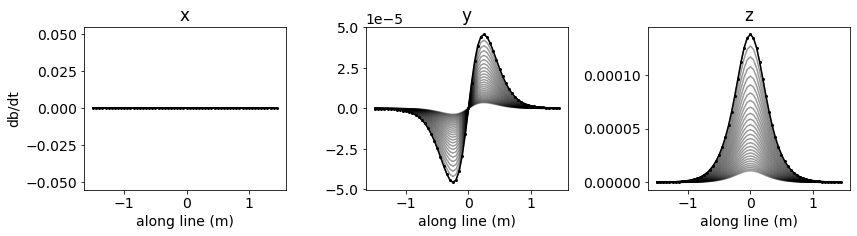

In [19]:
plot_data_profile(data)

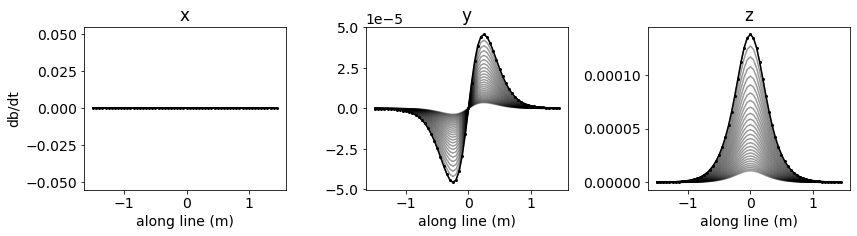

In [20]:
plot_data_profile(data_geoana);

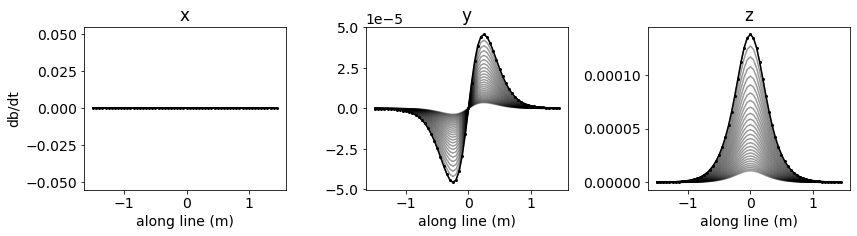

In [21]:
plot_data_profile(data_pm);

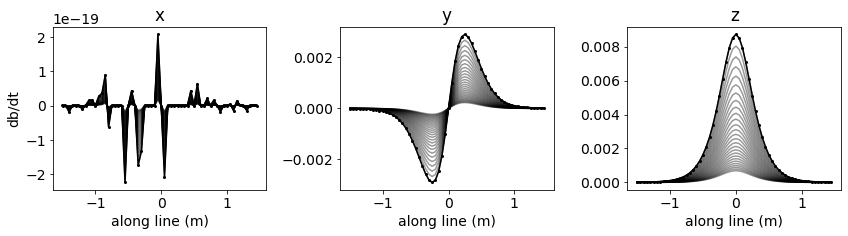

In [22]:
plot_data_profile(data_bt);

In [23]:
for i in range(3): 
    d0 = np.max(np.abs(data[i, :, :]))
    d1 = np.max(np.abs(data_bt[i, :, :]))
    print(f"{['x', 'y', 'z'][i]}: {d0:1.3e}, {d1:1.3e}, {d1/d0:1.5e}")

x: 0.000e+00, 2.240e-19, inf
y: 4.567e-05, 2.898e-03, 6.34549e+01
z: 1.376e-04, 8.717e-03, 6.33674e+01


/var/folders/lw/k5tlwhn57h96_sbv8smj_3dc0000gn/T/ipykernel_15437/196925242.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  print(f"{['x', 'y', 'z'][i]}: {d0:1.3e}, {d1:1.3e}, {d1/d0:1.5e}")


/var/folders/lw/k5tlwhn57h96_sbv8smj_3dc0000gn/T/ipykernel_15437/2110188910.py:1: RuntimeWarning: divide by zero encountered in true_divide
  ax = plot_data_profile(data_bt/data);
/var/folders/lw/k5tlwhn57h96_sbv8smj_3dc0000gn/T/ipykernel_15437/2110188910.py:1: RuntimeWarning: invalid value encountered in true_divide
  ax = plot_data_profile(data_bt/data);


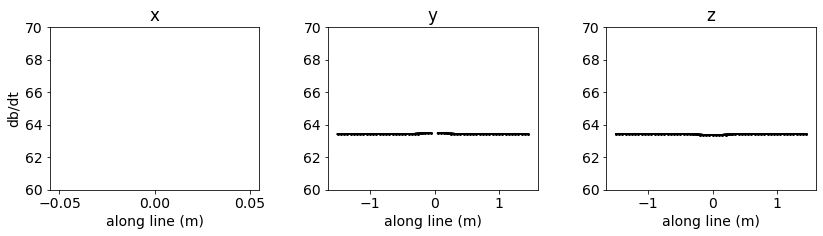

In [24]:
ax = plot_data_profile(data_bt/data);

for a in ax:
    a.set_ylim(60, 70)

## UltraTEM system

In [25]:
sensorinfo_ultratem = uxo_utils.load_sensor_info("UltraTEM")

In [26]:
n_lines = 1
line_length = 3
line_spacing = 0.5*line_length/n_lines
survey_dict_ultratem = uxo_utils.create_survey(
    sensorinfo_ultratem,
    times, 
    line_length=line_length,
    along_line_spacing=0.2,
    line_spacing=line_spacing,
    n_lines=n_lines,
    starting_point=np.r_[-1, 0]*line_length/2,
    z=z_tx,
    pitch=0,
    roll=0,
    yaw=0,
)

In [27]:
fwd_params_ultratem = uxo_utils.create_forward_modelling_params(
    sensorinfo_ultratem, times, 
    survey_dict_ultratem["mnum"], survey_dict_ultratem["pos"], 
    survey_dict_ultratem["pitch"], survey_dict_ultratem["roll"], survey_dict_ultratem["yaw"]
)

In [28]:
data_bt_ultratem_orig = uxo_utils.simulate_object(
    L1, L2, L3, fwd_params_ultratem, times, ord_loc, ord_ypr
)

In [29]:
sensor_table_ultratem = sensorinfo_ultratem.measNum2TxRxRxcCube()

In [30]:
rx = sensorinfo_ultratem.receivers[1]
rx_area = 0.1**2 #np.max(np.diff(rx.shape, axis=0))**2

In [31]:
# loop over transmitters
src_list_ultratem = []
nrx = sensor_table_ultratem[:, 3].max() + 1
ncomponents = sensor_table_ultratem[:, 2].max() + 1
ndata = nrx*ncomponents

for i, txi in enumerate(survey_dict_ultratem["txnum"]): 
    
    # reorder transmitter nodes so we are always doing right handed integrations
    tx = sensorinfo_ultratem.transmitters[txi]
    tx_corners = np.vstack([tx.shape[i, :] for i in [2, 1, 0, 3, 2]])
    tx_corners = tx_corners + survey_dict_ultratem["xyz"][i, :]

    receiver_inds = slice(i*ndata,i*ndata + nrx)

    receivers = pm.MagneticFluxDensityReceiver(
        survey_dict_ultratem["pos"][receiver_inds, :], 
        components=["z", "y", "x"],
        area=rx_area
    )
    src = pm.MagneticControlledSource(
        receiver_list=[receivers], location=tx_corners, current=tx.gain
    )
    src_list_ultratem.append(src)


In [32]:
survey_ultratem = pm.Survey(src_list_ultratem)
sim_ultratem = pm.SimulationPolarizabilityModel(np.atleast_2d(ord_loc), survey_ultratem)

In [33]:
tmp = sum([sim_ultratem.dpred(P[:, k]) for k in range(3)])

In [34]:
mnum_max = sensor_table_ultratem.shape[0]
n_along_line = int(survey_dict_ultratem["pos"].shape[0]/mnum_max)
data_pm_ultratem = np.empty((mnum_max, n_along_line, len(times)))

for j, P in enumerate(polarizabilities): 
    data_pm_ultratem[:, :, j] = sum([sim_ultratem.dpred(P[:, k]) for k in range(3)]).reshape(mnum_max, n_along_line, order="F")
    
    

In [35]:
ntx = int(survey_dict_ultratem["txnum"].max()) + 1

def reorder_mnum(sensor_table):
    return np.hstack([
        np.hstack([
                np.where(
                    (sensor_table_ultratem[:, 3] == rxi) & 
                    (sensor_table_ultratem[:, 0] == txi)
                )[0] for rxi in range(nrx)
        ]) for txi in range(ntx)
    ])

In [36]:
data_bt_ultratem_orig.shape

(165, 15, 27)

In [37]:
# find x, y indices, flip sign as Black tusk default integrates the other way
mnum_xy = (sensor_table_ultratem[:, 2] != 2)
data_bt_ultratem = data_bt_ultratem_orig.copy()
data_bt_ultratem[mnum_xy, :, :] = data_bt_ultratem_orig[mnum_xy, :, :] * -1

mnum_reordered = reorder_mnum(sensor_table_ultratem)
data_bt_ultratem = data_bt_ultratem[mnum_reordered, :, :]

(60.0, 70.0)

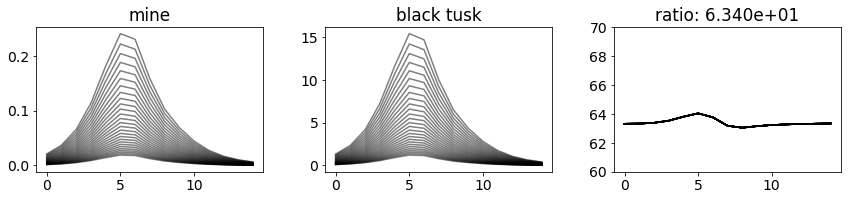

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
mnum_plot = 160

ax[0].plot(data_pm_ultratem[mnum_plot, :, :], alpha=0.5, color="k");
ax[1].plot(data_bt_ultratem[mnum_plot, :, :], alpha=0.5, color="k");
ax[2].plot(data_bt_ultratem[mnum_plot, :, :]/data_pm_ultratem[mnum_plot, :, :], alpha=0.5, color="k");

ax[0].set_title("mine")
ax[1].set_title("black tusk")
ax[2].set_title(f"ratio: {np.mean(data_bt_ultratem[mnum_plot, :, :]/data_pm_ultratem[mnum_plot, :, :]):1.3e}")
plt.tight_layout()

ax[2].set_ylim([60, 70])

In [39]:
ratio = np.mean(data_bt_ultratem[mnum_plot, :, :]/data_pm_ultratem[mnum_plot, :, :])
print(f"ratio: {ratio:1.3e}, inverse:{1/ratio:1.3e}")

ratio: 6.340e+01, inverse:1.577e-02


## compare with TDEM solution from SimPEG -- single loop transmitter

In [40]:
from discretize import CylindricalMesh
from SimPEG.electromagnetics import time_domain as tdem
from SimPEG import maps
from scipy.constants import inch, mu_0
from pymatsolver import Pardiso

In [41]:
radius = 4*inch

sigma_air = 1e-4

sigma_steel = 6e6
mur_steel = 150

sigma_aluminum = 3e7
mur_aluminum = 1

In [42]:

dx = 0.005
npad = 30
pf = 1.5
n_cells_per_radius = np.int64(np.ceil(radius/dx))
n_cells_vertical = np.int64(np.max([
    np.ceil(np.abs(ord_loc[2])/dx)+n_cells_per_radius, 
    np.ceil(np.abs(z_tx)/dx)
])) * 2

hx = [(dx, n_cells_per_radius + 10), (dx, npad, pf)]
hz = [(dx, npad, -pf), (dx, n_cells_vertical), (dx, npad, pf)]
mesh = CylindricalMesh([hx, [2*np.pi], hz], x0="00C")

<AxesSubplot:xlabel='x', ylabel='z'>

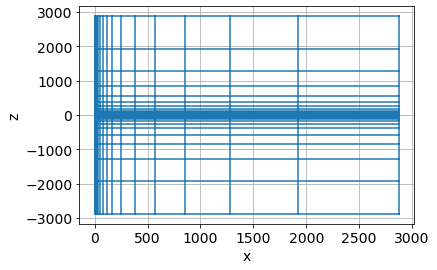

In [43]:
mesh.plot_grid()

In [44]:
"steel" in str(ordnance[ord_key]["common name"][ord_ind].lower())

False

In [45]:
sigma = sigma_air * np.ones(mesh.n_cells)
mur = np.ones(mesh.n_cells)

inds_sphere = (mesh.cell_centers[:, 0]**2 + (mesh.cell_centers[:, 2])**2) < radius**2

if "aluminum" in str(ordnance[ord_key]["common name"][ord_ind]).lower():
    sigma[inds_sphere] = sigma_aluminum 
elif "steel" in str(ordnance[ord_key]["common name"][ord_ind]).lower():
    sigma[inds_sphere] = sigma_steel
    mur[inds_sphere] = mur_steel

In [46]:
1260*np.sqrt(times.max()*1e-3/sigma_air)

6198.380433629417

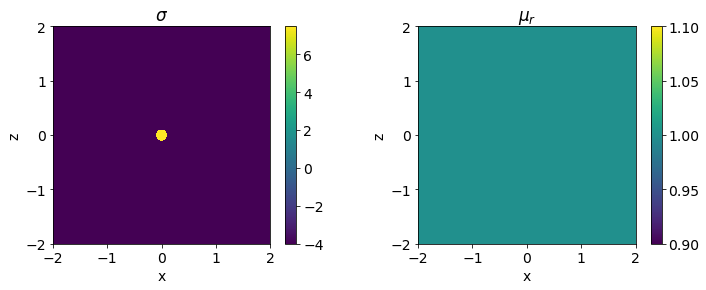

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
xlim = np.r_[-2, 2]
ylim = np.r_[-2, 2]

plt.colorbar(mesh.plot_image(np.log10(sigma), ax=ax[0], mirror=True)[0], ax=ax[0])
ax[0].set_title("$\sigma$")

plt.colorbar(mesh.plot_image(mur, ax=ax[1], mirror=True)[0], ax=ax[1])
ax[1].set_title("$\mu_r$")

for a in ax:
    a.set_xlim(xlim)
    a.set_ylim(ylim)
    a.set_aspect(1)

In [48]:
receiver_list = [
    tdem.receivers.PointMagneticFieldTimeDerivative(locations=np.r_[0, 0, z_tx], orientation=comp, times=times*1e-3)  
    for comp in ["z"]
]
tx_radius = 0.5
simpeg_source = tdem.sources.CircularLoop(
    receiver_list=receiver_list,
    location=np.r_[0, 0, z_tx], radius=tx_radius, current=1/(np.pi*tx_radius**2) # equivalent to a square with 1m width
) 

simpeg_survey = tdem.Survey([simpeg_source])

In [49]:
nsteps = 20
dt_list = [1e-8, 3e-8, 1e-7, 3e-7, 1e-6, 3e-6, 1e-5, 3e-5, 1e-4]
time_steps = [(dt, nsteps) for dt in dt_list] 

simulation = tdem.Simulation3DElectricField(
    mesh, time_steps=time_steps, survey=simpeg_survey,
    solver=Pardiso, sigmaMap=maps.IdentityMap(mesh),
    mu=mur*mu_0
) 

/Users/lindseyjh/git/simpeg/discretize/discretize/utils/code_utils.py:247: FutureWarning: meshTensor has been deprecated, please use unpack_widths. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


In [50]:
fields = simulation.fields(sigma)
dpred_simpeg = simulation.dpred(sigma, f=fields) * rx_width**2

/Users/lindseyjh/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/Users/lindseyjh/opt/miniconda3/envs/uxo/lib/python3.8/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(
/Users/lindseyjh/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.isSymmetric has been deprecated, please use CylindricalMesh.is_symmetric. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/Users/lindseyjh/git/simpeg/discretize/discretize/utils/code_utils.py:217: FutureWarning: CylindricalMesh.getFaceInnerProduct has been deprecated, please use CylindricalMesh.get_face_inner_product. It will be removed in version 1.0.0 of discretize.
  warnin

In [51]:
ind_center = int(len(survey_dict["xyz"][:, 1])/2)
survey_dict["xyz"][:, 1][ind_center]

0.0

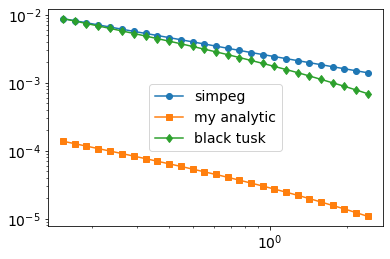

In [52]:
fig, ax = plt.subplots(1, 1)
ax.loglog(times, -dpred_simpeg, "-o", label="simpeg")
ax.loglog(times, data[2, ind_center, :], "-s", label="my analytic")
ax.loglog(times, data_bt[2, ind_center, :], "-d", label="black tusk")
ax.legend()

(0.001, 2)

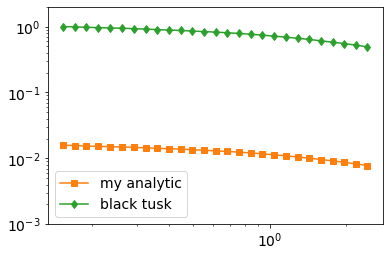

In [53]:
fig, ax = plt.subplots(1, 1)
ax.loglog(times, data[2, ind_center, :]/-dpred_simpeg, "C1-s", label="my analytic")
ax.loglog(times, data_bt[2, ind_center, :]/-dpred_simpeg, "C2-d", label="black tusk")
ax.legend()
ax.set_ylim([1e-3, 2])